
## Hyperparameter optimization 
### (optional, but encouraged--especially for determining the optimal number of inducing points)
***

In [1]:
import numpy as np
import pandas as pd
import os

import TRANSPIRE

## 1. Load data, define comparisons, and generate synthetic translocations 

see [this notebook](importing%20and%20manipulating%20data.ipynb) for greater detail

In [2]:
f = 'mydata.csv'
df = TRANSPIRE.data.import_data.load_data(f)

comparisons = [('uninfected', 'infected')]

synthetic_translocations = TRANSPIRE.data.generate_translocations.make_translocations(df, comparisons)
mapping, mapping_r = TRANSPIRE.utils.get_mapping(df)

synthetic_translocations.head()

1   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.121081   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.121081   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.121081   

                                                                                                                                                          2   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.378059   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.378059   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.378059   

                                                                                                                                                          3   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.287889   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.287889   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   
                                                      O00161      SNAP23      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   
                                                      O00186      STXBP3      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.287889   

                                                                                                                                                          4   \
accession_A gene name_A localization_A    condition_A accession_B gene name_B localization_B    condition_B label                                              
O00115      DNASE2      ER/Golgi/Lysosome uninfected  O00115      DNASE2      ER/Golgi/Lysosome infected    ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.142575   
                                                      O00116      AGPS        Peroxisome        infected    ER/Golgi/Lysosome to Peroxisome         0.142575   
                                                      O00151      PDLIM1      PM/Cytosol        infected    ER/Golgi/Lysosome to PM/Cytosol         0.1

## 2. Split the data into training, validation and testing partitions

In [3]:
f_train = 0.5 # fraction dedicated to training data
f_validate = 0.25 # fraction dedicated to validation (i.e. used to assess hyperparameter performance)
f_test = 0.25 # fraction dedicated to assessing final predictive performance

levels = ['condition_A', 'condition_B', 'label'] # groupby levels to take stratified samples from

X_train_df, X_validate_df, x_test_df = TRANSPIRE.utils.train_test_validate_split(synthetic_translocations, 
                                                                                 levels, 
                                                                                 f_train, 
                                                                                 f_validate, 
                                                                                 f_test)

Splitting data into training, validation, and testing folds (this may take a while) . . . done


## 3. Combine profiles across conditions to reduce computational load

We assume that the inherent nature of the data does not vary between conditions, and thus whichever hyperparameters perform best on all conditions combined should also perform best on the conditions individually. Combining the conditions and training the models on the mean value for a given profile across conditions can drastically reduce the computational load of hyperparameter optimization

_Note that in the case of this dataset, this doesn't have an affect since we only have two conditions to compare. However, this will save time in cases where your dataset has more than 2 conditions._

In [4]:
X_train_mean = X_train_df.groupby([n for n in X_train_df.index.names if not 'condition' in n]).mean()
X_validate_mean = X_validate_df.groupby([n for n in X_validate_df.index.names if not 'condition' in n]).mean()

X_train_mean.head() # notice that this dataframe doesn't have any "condition" levels

1   \
accession_A gene name_A localization_A    accession_B gene name_B localization_B    label                                              
O00115      DNASE2      ER/Golgi/Lysosome O00115      DNASE2      ER/Golgi/Lysosome ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.121081   
                                          O00116      AGPS        Peroxisome        ER/Golgi/Lysosome to Peroxisome         0.121081   
                                          O00151      PDLIM1      PM/Cytosol        ER/Golgi/Lysosome to PM/Cytosol         0.121081   
                                          O00217      NDUFS8      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.121081   
                                          O00483      NDUFA4      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.121081   

                                                                                                                                  2   \
accession_A gene name_A localization_A    accession_B gene name_B localization_B    label                                              
O00115      DNASE2      ER/Golgi/Lysosome O00115      DNASE2      ER/Golgi/Lysosome ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.378059   
                                          O00116      AGPS        Peroxisome        ER/Golgi/Lysosome to Peroxisome         0.378059   
                                          O00151      PDLIM1      PM/Cytosol        ER/Golgi/Lysosome to PM/Cytosol         0.378059   
                                          O00217      NDUFS8      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.378059   
                                          O00483      NDUFA4      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.378059   

                                                                                                                                  3   \
accession_A gene name_A localization_A    accession_B gene name_B localization_B    label                                              
O00115      DNASE2      ER/Golgi/Lysosome O00115      DNASE2      ER/Golgi/Lysosome ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.287889   
                                          O00116      AGPS        Peroxisome        ER/Golgi/Lysosome to Peroxisome         0.287889   
                                          O00151      PDLIM1      PM/Cytosol        ER/Golgi/Lysosome to PM/Cytosol         0.287889   
                                          O00217      NDUFS8      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.287889   
                                          O00483      NDUFA4      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.287889   

                                                                                                                                  4   \
accession_A gene name_A localization_A    accession_B gene name_B localization_B    label                                              
O00115      DNASE2      ER/Golgi/Lysosome O00115      DNASE2      ER/Golgi/Lysosome ER/Golgi/Lysosome to ER/Golgi/Lysosome  0.142575   
                                          O00116      AGPS        Peroxisome        ER/Golgi/Lysosome to Peroxisome         0.142575   
                                          O00151      PDLIM1      PM/Cytosol        ER/Golgi/Lysosome to PM/Cytosol         0.142575   
                                          O00217      NDUFS8      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.142575   
                                          O00483      NDUFA4      Mitochondria      ER/Golgi/Lysosome to Mitochondria       0.142575   

                                                                                                                                  5   \
accession_A gene name_A localization_A    accession_B gene name_B localization_B    label                                              
O00115      DNASE2      ER/Golgi/Lysosome O001

## 4. Split the training data into a given number of class-balanced folds

Depending on the number of markers in each class, the synthetic translocations generated may have a high level of class-imbalance. If there is overlap between organelle marker clases, this can result in classifier predictions that are biased toward the class with more samples.

To prevent prediction bias due to class imbalance, TRANSPIRE has a utility for generating different folds of balanced training data based on a given "imbalance_limit."

In general, more folds will yield better coverage of the training data, but at the expense of computation time. A highter imbalance_limit will overall increase coverage of the training data for a given fold, but may lead to poor model performance if there is high overlap between classes.

_Note: In contrast to k-fold cross-validation, these folds will overlap for any classes where the number of samples is less-than n_limit * n_folds_

In [5]:
imbalance_limit = 3 # maximum fold difference between smallest and largest class sizes
n_limit = X_train_mean.groupby('label').size().min()*imbalance_limit

print('The total number of folds required to cover all of the training data for each class is: {}'.format(np.ceil((X_train_mean.groupby('label').size()/n_limit).max())))

The total number of folds required to cover all of the training data for each class is: 129.0


In [6]:
n_folds = 5 # number of balanced folds to sample from the dataset
training_data = TRANSPIRE.utils.sample_balanced(X_train_mean, n_limit, n_folds)

Creating balanced training partitions (this may take a while).... done


## 5. Define possible combinations of hyperparameters 
### (e.g. kernel type and number of inducing points)

In general, the number of inducing points required will heavily depend on the extent of class separation, class number, and overall data quality. Below is a good starting point, but it should be adjusted on a per-dataset basis.

In [7]:
possible_n_induce = [1, 5, 10, 30, 75]

In our hands, the choice of kernel function has had a much lower impact on final model performance. Below are five different stationary kernels that are implemented in GPFlow. Again, the optimal kernel will ultimately vary dataset to dataset, but the choices below are a good starting point.

In [8]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import gpflow

possible_kernel_funcs = [
    gpflow.kernels.SquaredExponential, 
    gpflow.kernels.RationalQuadratic,
    gpflow.kernels.Matern32,
    gpflow.kernels.Matern52,
    gpflow.kernels.Exponential
]


In [9]:
import itertools

# create all possible combinations of the different n_induce, kernel_func options
possible_hyperparams = list(itertools.product(possible_n_induce, possible_kernel_funcs))

possible_hyperparams

[(1, gpflow.kernels.SquaredExponential),
 (1, gpflow.kernels.RationalQuadratic),
 (1, gpflow.kernels.Matern32),
 (1, gpflow.kernels.Matern52),
 (1, gpflow.kernels.Exponential),
 (5, gpflow.kernels.SquaredExponential),
 (5, gpflow.kernels.RationalQuadratic),
 (5, gpflow.kernels.Matern32),
 (5, gpflow.kernels.Matern52),
 (5, gpflow.kernels.Exponential),
 (10, gpflow.kernels.SquaredExponential),
 (10, gpflow.kernels.RationalQuadratic),
 (10, gpflow.kernels.Matern32),
 (10, gpflow.kernels.Matern52),
 (10, gpflow.kernels.Exponential),
 (30, gpflow.kernels.SquaredExponential),
 (30, gpflow.kernels.RationalQuadratic),
 (30, gpflow.kernels.Matern32),
 (30, gpflow.kernels.Matern52),
 (30, gpflow.kernels.Exponential),
 (75, gpflow.kernels.SquaredExponential),
 (75, gpflow.kernels.RationalQuadratic),
 (75, gpflow.kernels.Matern32),
 (75, gpflow.kernels.Matern52),
 (75, gpflow.kernels.Exponential)]

## 6. Compute inducing point arrays up-front (optional)

There are no downsides to performing this step, but it will prevent repeat KMeans fitting of the inducing points in the event that there are multiple hyperparameter combinations with the same n_induce

In [23]:
import TRANSPIRE.training

# fit KMeans to training data for different n_induce
Z_induce = {}

for n_induce in possible_n_induce:
    
    Z_induce[n_induce] = {}
    
    for k, x in training_data.groupby('fold'):
        
        Z_induce[n_induce][k] = TRANSPIRE.training.compute_inducing(x, n_induce)
    
    print(n_induce, end=', ')

1, 5, 10, 30, 75, 

## 7. Train and save models for each combination of hyperparameters

#### define static model parameters

In [10]:
# where to save the models (make sure that this path exists)
base_dir = 'hyperparameter_opt'

# max number of calls to the optimizer for each model that is built
maxiter = 200

# learning rate for the Adam optimizer 
# too low of a learning rate will prevent the model from reaching an optimal solution
# too high and the fitting may diverge
# 0.05 is a good starting point
learning_rate = 0.05

# whether to implement interactive plotting to track fit progress
plot_fit = True

**custom callback to visualize model training**

In [24]:
%matplotlib inline

from IPython import display

class PlottingCallback(TRANSPIRE.training.ProgressTracker):
    def __init__(self, m, X, Y, update_interval):
        super().__init__(m, X, Y)
        
        self.calls = 0
        self.update_interval = update_interval
        self.update()
        
        ax.set_xlim(0, maxiter+1)
        ax.set_ylim(self.elbo[0], 0)
        ax_2.set_ylim(0, 1)
         
    def update_plot(self, i):
        self.calls+=1
        self.update()
                
        if self.calls%self.update_interval == 0:
            ax.set_title('iteration # {}'.format(self.calls))
        
            x = [int(self.update_interval*i) for i in range(int(np.ceil(len(self.elbo)/self.update_interval)))]
            elbo = [np.mean(np.array(self.elbo)[x[i]:x[i+1]]) for i in range(len(x)-1)]
            acc = [np.mean(np.array(self.acc)[x[i]:x[i+1]]) for i in range(len(x)-1)]
           
            elbo_line, = ax.plot(x[:-1], elbo, color = 'grey', label='ELBO')
            acc_line, = ax_2.plot(x[:-1], acc, color='steelblue', label= 'accuracy')
            
            ax.set_xlabel('iteration #')
            ax.set_ylabel('ELBO')
            ax_2.set_ylabel('accuracy')
            
            ax.legend(handles=[elbo_line, acc_line], loc=4)

            fig.tight_layout()
            
            display.clear_output(wait=True)
            display.display(fig)
    

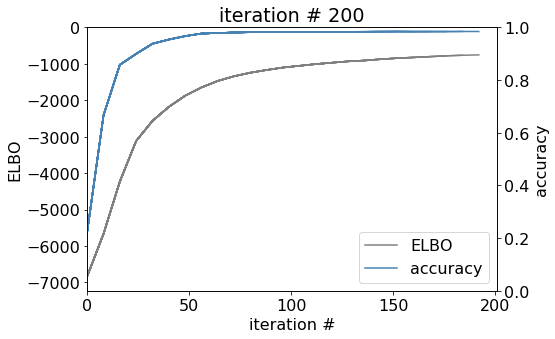

In [27]:

if plot_fit == True:
    
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16})
    
    # for tracking fitting progress  
    fig = plt.figure(figsize = (8, 5))
    ax = fig.add_subplot(111)
    ax_2 = ax.twinx()
    plt.show()
    
    
# just in case the training process is stopped part way through
gpflow.reset_default_graph_and_session()

for n_induce, kern_func in possible_hyperparams:
    
    # make a new directory for the models denoting the model architecture
    hyper_dir = os.path.join(base_dir, 'n={}_kernel={}'.format(n_induce, str(kern_func).split('.')[-1].strip("'>")))
    
    # if this directory doesn't alredy exist, make it
    if not os.path.exists(hyper_dir):
        os.mkdir(hyper_dir)
    
    # build and fit a model for each balanced fold of training data
    for k, X_train in training_data.groupby('fold'):
        
        # check if a model with this architecture already exists 
        # (useful if you want to pause and resume training)
        if not k in [int(f.split('_')[-1]) for f in os.listdir(hyper_dir)]: 
        
            if plot_fit == True:
                ax.clear()
                ax_2.clear()

            X = X_train.values
            y = X_train.index.get_level_values('label').map(mapping).values.reshape(-1, 1) # encode labels
            Z = Z_induce[n_induce][k] # set of inducing points already pre-calculated

            # define kernel function (with noise kernel added)
            kernel = kern_func(X.shape[1], ARD=True) + gpflow.kernels.White(X.shape[1], variance=1)

            # parameters required to build model
            model_params = {

                'Z': Z, # if Z is omitted from this dict, KMeans will be used to find n_inducing points during moldel generation
                'n_induce': n_induce, # only really required if Z is omitted
                'kernel': kernel,
            }

            # build the SVGP model
            m = TRANSPIRE.training.build_model(X, y, **model_params)

            # allow the optimizer to train both inducing points and the noise level 
            # (optional...one or more may be set to false--up to user-discretion)
            m.feature.Z.trainable = True
            m.kern.kernels[1].trainable = True

            session = gpflow.get_default_session()

            if plot_fit == True:

                window = max(1, int(maxiter/25))
                callback = PlottingCallback(m, X, y, window)

                opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
                opt.minimize(m, maxiter=maxiter, step_callback=callback.update_plot)

            else:

                opt = gpflow.training.AdamOptimizer(learning_rate=learning_rate)
                opt.minimize(m, maxiter=maxiter)

            # save the optimized model 
            m.anchor(session)
            gpflow.saver.Saver().save(os.path.join(hyper_dir, 'ELBO={:.0f}_{}'.format(m.compute_log_likelihood(X), k)), m)

            # this line is EXTREMELY IMPORTANT to prevent the tensorflow graph from continuing to grow call-after-call
            gpflow.reset_default_graph_and_session()


## 8. Evaluate each model on the validation data

In [11]:
results = {}

eval_limit = 10000 # max number of samples to evaluate at once (conserve RAM usage)
n_chunks = int(np.ceil(X_validate_mean.shape[0]/eval_limit))

for n_induce, kern_func in possible_hyperparams:
    
    hyper_dir = os.path.join(base_dir, 'n={}_kernel={}'.format(n_induce, str(kern_func).split('.')[-1].strip("'>")))
    
    if not os.path.exists(hyper_dir):
        
       raise FileNotFoundError()
    
    # iterate through files (e.g. models) in the directory
    for file in os.listdir(hyper_dir):
        
        fold = file.split('_')[-1]
        key = (n_induce, str(kern_func).split('.')[-1].strip("'>"), fold)

        # load the optimized model from its directory
        m = gpflow.saver.Saver().load(os.path.join(hyper_dir, file))
        
        # iterate through the validation partition and evaluate model performance, save results in a dataframe
        means = []
        
        for i, arr in enumerate(np.array_split(X_validate_mean, n_chunks)):
            means.append(pd.DataFrame(m.predict_y(arr.values)[0], index=arr.index))
        
        # this line is EXTREMELY IMPORTANT to prevent the tensorflow graph from continuing to grow call-after-call
        gpflow.reset_default_graph_and_session()
        
        # combine results into a single dataframe
        means = pd.concat(means)
        
        # compute metrics to evaluate performance....
        results[key] = TRANSPIRE.performance.eval_report(means, mapping, mapping_r)
        
    print(n_induce, kern_func)

# combine results into a single dataframe
results = pd.concat(results, names = ['n induce', 'kernel', 'fold'])

# save results so you don't have to do the training again!
results.to_frame().to_csv(os.path.join(base_dir, 'hyperparameter_opt_results.csv'))

1 <class 'gpflow.kernels.SquaredExponential'>
1 <class 'gpflow.kernels.RationalQuadratic'>
1 <class 'gpflow.kernels.Matern32'>
1 <class 'gpflow.kernels.Matern52'>
1 <class 'gpflow.kernels.Exponential'>
5 <class 'gpflow.kernels.SquaredExponential'>
5 <class 'gpflow.kernels.RationalQuadratic'>
5 <class 'gpflow.kernels.Matern32'>
5 <class 'gpflow.kernels.Matern52'>
5 <class 'gpflow.kernels.Exponential'>
10 <class 'gpflow.kernels.SquaredExponential'>
10 <class 'gpflow.kernels.RationalQuadratic'>
10 <class 'gpflow.kernels.Matern32'>
10 <class 'gpflow.kernels.Matern52'>
10 <class 'gpflow.kernels.Exponential'>
30 <class 'gpflow.kernels.SquaredExponential'>
30 <class 'gpflow.kernels.RationalQuadratic'>
30 <class 'gpflow.kernels.Matern32'>
30 <class 'gpflow.kernels.Matern52'>
30 <class 'gpflow.kernels.Exponential'>
75 <class 'gpflow.kernels.SquaredExponential'>
75 <class 'gpflow.kernels.RationalQuadratic'>
75 <class 'gpflow.kernels.Matern32'>
75 <class 'gpflow.kernels.Matern52'>
75 <class 'gpfl

In [19]:
results

n induce  kernel              fold  type of metric        metric                         
1         SquaredExponential  5     F1 score (per class)  DC/Nucleus to DC/Nucleus           0.000000
                                                          DC/Nucleus to ER/Golgi/Lysosome    0.042781
                                                          DC/Nucleus to Mitochondria         0.042105
                                                          DC/Nucleus to PM/Cytosol           0.000000
                                                          DC/Nucleus to Peroxisome           0.000000
                                                                                               ...   
75        Exponential         5     singular metrics      F1 score (micro)                   0.989231
                                                          F1 score (macro)                   0.946134
                                                          F1 score (weighted)                0

## 9. Visualize the results and determine optimal hyperparameters

The cell below will plot two different kinds of metrics to help you decide what hyperparameters are the best. Note that the best F1 score is 1.0 and the worst F1 score is 0.0. On the other hand, the best loss is 0.0. In the binary classification setting, a classifier that is uninformative (e.g. no better than chance) will have a loss of >=0.7. In the multi-class case, an uninformative classifier will yield loss >= -log(1/M) where M is the total number of classes. 

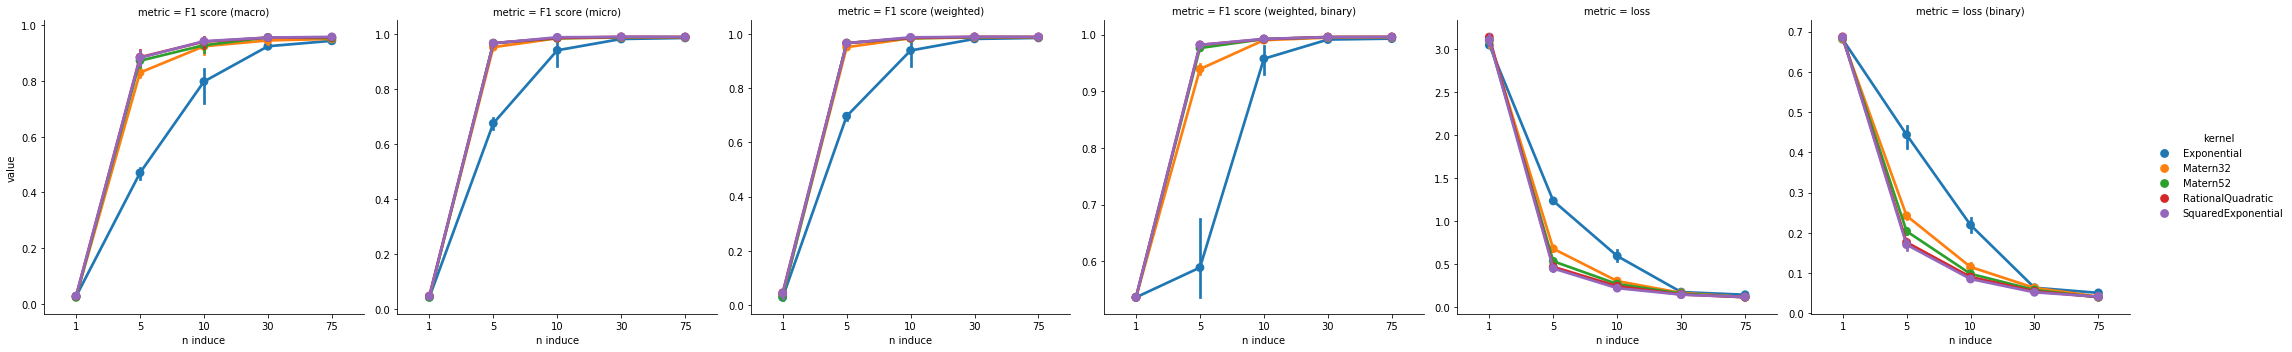

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

temp = results.unstack('type of metric')['singular metrics'].dropna()
sns.catplot(data=temp.reset_index().melt(temp.index.names), col='metric', 
            hue='kernel', sharey=False, x='n induce', y='value', kind='point')

plt.show()

You can now take your chosen hyperparameters forward for final model fitting

For this dataset, it appears that in general, the squared exponential, matern, and rational quatratic kernels all perform relatively similarly on the data. The exponential kernel, however, performs worse. We can also see that this data is sufficiently described by ~30 inducing points.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>